In [70]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [71]:
from glob import glob

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotx
import pandas as pd
from fastcore.xtras import load_pickle
from scipy.stats import sem

from gptchem.evaluator import find_learning_curve_intersection, fit_learning_curve, lc
from gptchem.plotsettings import *
from gptchem.settings import (
    ONE_COL_GOLDEN_RATIO_HEIGHT_INCH,
    ONE_COL_WIDTH_INCH,
    TWO_COL_GOLDEN_RATIO_HEIGHT_INCH,
)

%matplotlib inline

## Load Ngram results

In [72]:
ngram_results = glob('ngram_baseline/*.pkl')

all_results_ngram = []

for result in ngram_results:
    all_results_ngram.append(load_pickle(result))

In [73]:
all_results_ngram = pd.DataFrame(all_results_ngram)

In [75]:
all_results_ngram

,accuracy,acc_macro,racc,kappa,confusion_matrix,f1_macro,f1_micro,frac_valid,all_y_true,all_y_pred,valid_indices,might_have_rounded_floats,train_size,num_classes,representation
0,0.5,0.50,0.5,0.0,"((0, {0: 50, 1: 0}), (1, {0: 50, 1: 0}))",0.333333,0.5,1.0,"[0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,100,2,rxn
1,0.2,0.68,0.2,0.0,"((0, {0: 20, 1: 0, 2: 0, 3: 0, 4: 0}), (1, {0:...",0.066667,0.2,1.0,"[4, 3, 4, 2, 4, 2, 2, 4, 4, 3, 0, 2, 2, 2, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,10,5,rxn
2,0.2,0.68,0.2,0.0,"((0, {0: 20, 1: 0, 2: 0, 3: 0, 4: 0}), (1, {0:...",0.066667,0.2,1.0,"[3, 4, 3, 4, 4, 4, 4, 3, 1, 1, 2, 1, 2, 1, 2, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,10,5,rxn
3,0.2,0.68,0.2,0.0,"((0, {0: 20, 1: 0, 2: 0, 3: 0, 4: 0}), (1, {0:...",0.066667,0.2,1.0,"[2, 3, 0, 0, 1, 2, 2, 2, 1, 3, 0, 4, 1, 1, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,200,5,rxn
4,0.5,0.50,0.5,0.0,"((0, {0: 50, 1: 0}), (1, {0: 50, 1: 0}))",0.333333,0.5,1.0,"[0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,200,2,rxn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
335,0.2,0.68,0.2,0.0,"((0, {0: 20, 1: 0, 2: 0, 3: 0, 4: 0}), (1, {0:...",0.066667,0.2,1.0,"[3, 0, 0, 3, 1, 3, 4, 4, 4, 3, 0, 1, 3, 2, 3, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,500,5,rxn
336,0.2,0.68,0.2,0.0,"((0, {0: 20, 1: 0, 2: 0, 3: 0, 4: 0}), (1, {0:...",0.066667,0.2,1.0,"[0, 0, 1, 3, 4, 3, 2, 4, 1, 2, 4, 3, 0, 0, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,200,5,rxn
337,0.2,0.68,0.2,0.0,"((0, {0: 20, 1: 0, 2: 0, 3: 0, 4: 0}), (1, {0:...",0.066667,0.2,1.0,"[4, 0, 4, 1, 2, 4, 0, 4, 2, 4, 3, 2, 4, 0, 1, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,100,5,rxn
338,0.2,0.68,0.2,0.0,"((0, {0: 20, 1: 0, 2: 0, 3: 0, 4: 0}), (1, {0:...",0.066667,0.2,1.0,"[4, 3, 1, 1, 1, 4, 3, 0, 3, 0, 0, 3, 0, 3, 4, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",False,20,5,rxn


In [76]:
results_ngram_grouped = all_results_ngram[['num_classes', 'train_size', 'accuracy', 'f1_macro', 'f1_micro', 'kappa']].groupby(['num_classes', 'train_size']).agg(['mean', 'std', sem])

In [77]:
results_ngram_grouped

accuracy                     f1_macro       \
                           mean  std           sem      mean  std   
num_classes train_size                                              
2           10              0.5  0.0  0.000000e+00  0.333333  0.0   
            20              0.5  0.0  0.000000e+00  0.333333  0.0   
            50              0.5  0.0  0.000000e+00  0.333333  0.0   
            100             0.5  0.0  0.000000e+00  0.333333  0.0   
            200             0.5  0.0  0.000000e+00  0.333333  0.0   
            500             0.5  0.0  0.000000e+00  0.333333  0.0   
5           10              0.2  0.0  1.030816e-17  0.066667  0.0   
            20              0.2  0.0  1.030816e-17  0.066667  0.0   
            50              0.2  0.0  1.030816e-17  0.066667  0.0   
            100             0.2  0.0  1.030816e-17  0.066667  0.0   
            200             0.2  0.0  1.030816e-17  0.066667  0.0   
            500             0.2  0.0  6.367566e-18  0.066667  0.0   

                                     f1_micro                    kappa       \
                                 sem     mean  std           sem  mean  std   
num_classes train_size                                                        
2           10          2.061632e-17      0.5  0.0  0.000000e+00   0.0  0.0   
            20          2.061632e-17      0.5  0.0  0.000000e+00   0.0  0.0   
            50          2.061632e-17      0.5  0.0  0.000000e+00   0.0  0.0   
            100         2.061632e-17      0.5  0.0  0.000000e+00   0.0  0.0   
            200         2.061632e-17      0.5  0.0  0.000000e+00   0.0  0.0   
            500         1.273513e-17      0.5  0.0  0.000000e+00   0.0  0.0   
5           10          0.000000e+00      0.2  0.0  1.030816e-17   0.0  0.0   
            20          0.000000e+00      0.2  0.0  1.030816e-17   0.0  0.0   
            50          0.000000e+00      0.2  0.0  1.030816e-17   0.0  0.0   
            100         0.000000e+00      0.2  0.0  1.030816e-17   0.0  0.0   
            200         0.000000e+00      0.2  0.0  1.030816e-17   0.0  0.0   
            500         0.000000e+00      0.2  0.0  6.367566e-18   0.0  0.0   

                             
                        sem  
num_classes train_size       
2           10          0.0  
            20          0.0  
            50          0.0  
            100         0.0  
            200         0.0  
            500         0.0  
5           10          0.0  
            20          0.0  
            50          0.0  
            100         0.0  
            200         0.0  
            500         0.0

## Load results

In [78]:
all_out = glob("out/**/*.pkl")

In [79]:
all_out = [load_pickle(p) for p in all_out]

In [80]:
extracted_res = []
xgboost_results = []
tabpfn_results = []

for out in all_out:
    res = {
        "train_size": out["train_size"],
        "frac_valid": out["frac_valid"],
        "accuracy": out["accuracy"],
        "f1_macro": out["f1_macro"],
        "f1_micro": out["f1_micro"],
        "kappa": out["kappa"],
        "num_classes": out["num_classes"],
    }

    xgb_res = {
        "train_size": out["train_size"],
        "accuracy": out["xgboost_baseline"]["accuracy"],
        "f1_macro": out["xgboost_baseline"]["f1_macro"],
        "f1_micro": out["xgboost_baseline"]["f1_micro"],
        "kappa": out["xgboost_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    tabpfn_res = {
        "train_size": out["train_size"],
        "accuracy": out["tabpfn_baseline"]["accuracy"],
        "f1_macro": out["tabpfn_baseline"]["f1_macro"],
        "f1_micro": out["tabpfn_baseline"]["f1_micro"],
        "kappa": out["tabpfn_baseline"]["kappa"],
        "num_classes": out["num_classes"],
    }

    extracted_res.append(res)
    xgboost_results.append(xgb_res)
    tabpfn_results.append(tabpfn_res)

In [81]:
res = pd.DataFrame(extracted_res)
xgboost_res = pd.DataFrame(xgboost_results)
tabpfn_res = pd.DataFrame(tabpfn_results)

In [82]:
grouped_res = res.groupby(["num_classes", "train_size"]).agg(["mean", "std", "count", sem])

In [83]:
grouped_xgboost_res = xgboost_res.groupby(["num_classes", "train_size"]).agg(
    ["mean", "std", "count", sem]
)

In [84]:
grouped_tabpfn_res = tabpfn_res.groupby(["num_classes", "train_size"]).agg(
    ["mean", "std", "count", sem]
)

In [85]:
grouped_res.loc[2, :]

frac_valid                  accuracy                            \
                 mean  std count  sem      mean       std count       sem   
train_size                                                                  
10                1.0  0.0     4  0.0  0.583000  0.064114     4  0.032057   
20                1.0  0.0     5  0.0  0.676800  0.034339     5  0.015357   
50                1.0  0.0     5  0.0  0.742400  0.046355     5  0.020731   
100               1.0  0.0     5  0.0  0.871200  0.042464     5  0.018991   
200               1.0  0.0     3  0.0  0.934667  0.015144     3  0.008743   
500               1.0  0.0     5  0.0  0.933600  0.013145     5  0.005879   

            f1_macro                            f1_micro                  \
                mean       std count       sem      mean       std count   
train_size                                                                 
10          0.537379  0.106531     4  0.053266  0.583000  0.064114     4   
20          0.664946  0.050435     5  0.022555  0.676800  0.034339     5   
50          0.740264  0.048005     5  0.021468  0.742400  0.046355     5   
100         0.870830  0.042595     5  0.019049  0.871200  0.042464     5   
200         0.934654  0.015132     3  0.008736  0.934667  0.015144     3   
500         0.933561  0.013145     5  0.005879  0.933600  0.013145     5   

                         kappa                            
                 sem      mean       std count       sem  
train_size                                                
10          0.032057  0.166000  0.128229     4  0.064114  
20          0.015357  0.353600  0.068679     5  0.030714  
50          0.020731  0.484800  0.092710     5  0.041461  
100         0.018991  0.742400  0.084928     5  0.037981  
200         0.008743  0.869333  0.030288     3  0.017487  
500         0.005879  0.867200  0.026291     5  0.011758

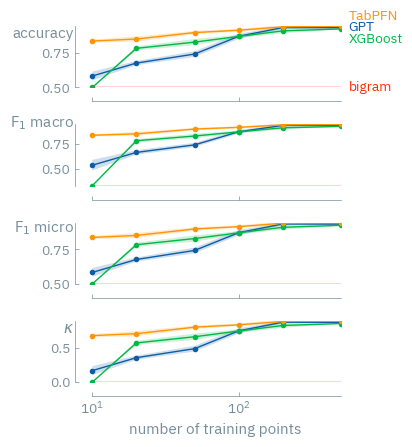

In [86]:
fig, ax = plt.subplots(
    4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
)

# plot the binary case, i.e. num_classes = 2

ax[0].set_xscale("log")
for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    range_frame(
        ax[i],
        grouped_res.loc[2, :].index,
        np.stack(
            [
                grouped_res.loc[2, :][metric]["mean"],
                grouped_xgboost_res.loc[2, :][metric]["mean"],
                grouped_tabpfn_res.loc[2, :][metric]["mean"],
            ]
        ).flatten(),
        0.001,
    )
    ax[i].plot(
        grouped_res.loc[2, :].index,
        grouped_res.loc[2, :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[2, :].index,
        grouped_res.loc[2, :][metric]["mean"] - grouped_res.loc[2, :][metric]["sem"],
        grouped_res.loc[2, :][metric]["mean"] + grouped_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :][metric]["mean"]
        - grouped_xgboost_res.loc[2, :][metric]["sem"],
        grouped_xgboost_res.loc[2, :][metric]["mean"]
        + grouped_xgboost_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :][metric]["mean"] - grouped_tabpfn_res.loc[2, :][metric]["sem"],
        grouped_tabpfn_res.loc[2, :][metric]["mean"] + grouped_tabpfn_res.loc[2, :][metric]["sem"],
        alpha=0.2,
    )

    ax[i].plot(
        results_ngram_grouped.loc[2, :].index,
        results_ngram_grouped.loc[2, :][metric]["mean"],
        label="bigram",
    )

    ax[i].fill_between(
        results_ngram_grouped.loc[2, :].index,
        results_ngram_grouped.loc[2, :][metric]["mean"]
        - results_ngram_grouped.loc[2, :][metric]["sem"],
        results_ngram_grouped.loc[2, :][metric]["mean"]
        + results_ngram_grouped.loc[2, :][metric]["sem"],
        alpha=0.2,
    )


matplotx.line_labels(ax[0])
ylabel_top("accuracy", ax=ax[0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], y_pad=0.1, x_pad=0.04)
ylabel_top(r"$\kappa$", ax=ax[3], y_pad=0.1, x_pad=0.04)
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
ax[-1].set_xlabel("number of training points", labelpad=4)


fig.savefig("polymner-classification_results_2.pdf", bbox_inches="tight")

/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/plotutils.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(x_min - pad * (x_max - x_min), x_max + pad * (x_max - x_min))


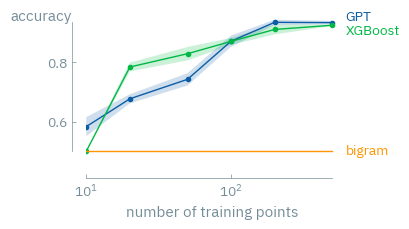

In [87]:
fig, ax = plt.subplots(1,1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))

ax.set_xscale("log")

ax.plot(
    grouped_res.loc[2, :].index,
    grouped_res.loc[2, :]["accuracy"]["mean"],
    marker="o",
    label="GPT",
)

ax.fill_between(
    grouped_res.loc[2, :].index,
    grouped_res.loc[2, :]["accuracy"]["mean"] - grouped_res.loc[2, :]["accuracy"]["sem"],
    grouped_res.loc[2, :]["accuracy"]["mean"] + grouped_res.loc[2, :]["accuracy"]["sem"],
    alpha=0.2,
)

ax.plot(
    grouped_xgboost_res.loc[2, :].index,
    grouped_xgboost_res.loc[2, :]["accuracy"]["mean"],
    marker="o",
    label="XGBoost",
)

ax.fill_between(
    grouped_xgboost_res.loc[2, :].index,
    grouped_xgboost_res.loc[2, :]["accuracy"]["mean"]
    - grouped_xgboost_res.loc[2, :]["accuracy"]["sem"],
    grouped_xgboost_res.loc[2, :]["accuracy"]["mean"]
    + grouped_xgboost_res.loc[2, :]["accuracy"]["sem"],
    alpha=0.2,
)


ax.plot(
    results_ngram_grouped.loc[2, :].index,
    results_ngram_grouped.loc[2, :]["accuracy"]["mean"],
    label="bigram",
)

ax.fill_between(
    results_ngram_grouped.loc[2, :].index,
    results_ngram_grouped.loc[2, :]["accuracy"]["mean"]
    - results_ngram_grouped.loc[2, :]["accuracy"]["sem"],
    results_ngram_grouped.loc[2, :]["accuracy"]["mean"]
    + results_ngram_grouped.loc[2, :]["accuracy"]["sem"],
    alpha=0.2,
)

range_frame(
    ax,
    grouped_res.loc[2, :].index,
    np.concatenate(
        [
            grouped_res.loc[2, :]["accuracy"]["mean"],
            grouped_xgboost_res.loc[2, :]["accuracy"]["mean"],
            results_ngram_grouped.loc[2, :]["accuracy"]["mean"],
        ]
    ),
)

ax.set_xlabel("number of training points")
ylabel_top("accuracy", ax=ax, y_pad=0.15, x_pad=0.04)

matplotx.line_labels(ax)

fig.savefig("polyner-classification_results_2_acc.pdf", bbox_inches="tight")

In [88]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_xgboost_res.loc[2, :].index,
        grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/evaluator.py:582: RuntimeWarning: overflow encountered in exp
  return -a * np.exp(-b * x) + c


1.3609255190612268

In [89]:
find_learning_curve_intersection(
    grouped_res.loc[2, :]["f1_macro"]["mean"].values[0],
    fit_learning_curve(
        grouped_tabpfn_res.loc[2, :].index,
        grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
    )[0],
) / 10

0.3788486093015747

In [90]:
intersections = []

for i, val in enumerate(grouped_res.loc[2, :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[2, :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_xgboost_res.loc[2, :].index,
                grouped_xgboost_res.loc[2, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections.append(factor)


intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[2, :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[2, :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_tabpfn_res.loc[2, :].index,
                grouped_tabpfn_res.loc[2, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections_tabpfn.append(factor)

/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [91]:
from gptchem.evaluator import add_kappa_vlines

/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/plotutils.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(x_min - pad * (x_max - x_min), x_max + pad * (x_max - x_min))


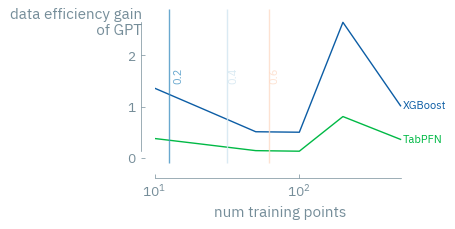

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))

ax.plot(
    grouped_res.loc[
        2,
        :,
    ].index,
    intersections,
    label="XGBoost",
)
ax.plot(
    grouped_res.loc[
        2,
        :,
    ].index,
    intersections_tabpfn,
    label="TabPFN",
)

matplotx.line_labels(fontsize=8)
add_kappa_vlines(
    grouped_res.loc[2, :].index, grouped_res.loc[2, :]["kappa"]["mean"], ymax=2.9, ymin=-0.1
)
ylabel_top("data efficiency gain\n  of GPT", x_pad=0.03)
plt.xlabel("num training points", labelpad=4)

plt.xscale("log")

range_frame(
    ax,
    grouped_res.loc[
        2,
        :,
    ].index,
    np.stack([intersections, intersections_tabpfn]).flatten(),
)
plt.savefig("polymer-2-data-efficiency.pdf", bbox_inches="tight")

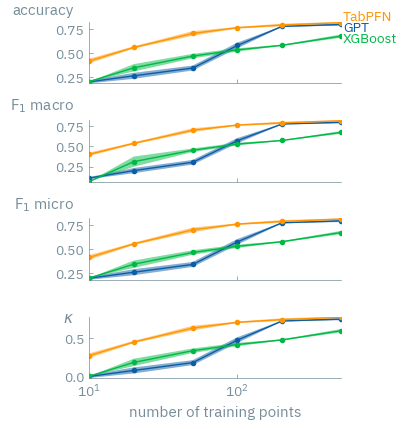

In [93]:
# with plt.style.context(matplotx.styles.dufte):
fig, ax = plt.subplots(
    4, 1, figsize=(ONE_COL_WIDTH_INCH, TWO_COL_GOLDEN_RATIO_HEIGHT_INCH), sharex="all"
)

# plot the binary case, i.e. num_classes = 2

for i, metric in enumerate(["accuracy", "f1_macro", "f1_micro", "kappa"]):
    ax[i].plot(
        grouped_res.loc[5, :].index,
        grouped_res.loc[5, :][metric]["mean"],
        marker="o",
        label="GPT",
    )
    ax[i].fill_between(
        grouped_res.loc[5, :].index,
        grouped_res.loc[5, :][metric]["mean"] - grouped_res.loc[5, :][metric]["sem"],
        grouped_res.loc[5, :][metric]["mean"] + grouped_res.loc[5, :][metric]["sem"],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_xgboost_res.loc[5, :].index,
        grouped_xgboost_res.loc[5, :][metric]["mean"],
        marker="o",
        label="XGBoost",
    )
    ax[i].fill_between(
        grouped_xgboost_res.loc[5, :].index,
        grouped_xgboost_res.loc[5, :][metric]["mean"]
        - grouped_xgboost_res.loc[5, :][metric]["sem"],
        grouped_xgboost_res.loc[5, :][metric]["mean"]
        + grouped_xgboost_res.loc[5, :][metric]["sem"],
        alpha=0.5,
    )

    ax[i].plot(
        grouped_tabpfn_res.loc[5, :].index,
        grouped_tabpfn_res.loc[5, :][metric]["mean"],
        marker="o",
        label="TabPFN",
    )
    ax[i].fill_between(
        grouped_tabpfn_res.loc[5, :].index,
        grouped_tabpfn_res.loc[5, :][metric]["mean"] - grouped_tabpfn_res.loc[5, :][metric]["sem"],
        grouped_tabpfn_res.loc[5, :][metric]["mean"] + grouped_tabpfn_res.loc[5, :][metric]["sem"],
        alpha=0.5,
    )


matplotx.line_labels(ax[0])
ylabel_top("accuracy", ax=ax[0], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ macro", ax=ax[1], y_pad=0.1, x_pad=0.04)
ylabel_top(r"F$_{1}$ micro", ax=ax[2], y_pad=0.1, x_pad=0.04)
ylabel_top(r"$\kappa$", ax=ax[3], y_pad=0.1, x_pad=0.04)
plt.subplots_adjust(hspace=0.6, top=1, bottom=0.2)
ax[-1].set_xlabel("number of training points", labelpad=4)


ax[0].set_xscale("log")
fig.savefig("polymner-classification_results_5.pdf", bbox_inches="tight")

In [94]:
intersections = []

for i, val in enumerate(grouped_res.loc[5, :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[5, :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_xgboost_res.loc[5, :].index,
                grouped_xgboost_res.loc[5, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections.append(factor)


intersections_tabpfn = []

for i, val in enumerate(grouped_res.loc[5, :].index):
    factor = (
        find_learning_curve_intersection(
            grouped_res.loc[5, :]["f1_macro"]["mean"].values[i],
            fit_learning_curve(
                grouped_tabpfn_res.loc[5, :].index,
                grouped_tabpfn_res.loc[5, :]["f1_macro"]["mean"],
            )[0],
        )
        / val
    )

    intersections_tabpfn.append(factor)

/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/evaluator.py:582: RuntimeWarning: overflow encountered in exp
  return -a * np.exp(-b * x) + c
/Users/kevinmaikjablonka/miniconda3/envs/gptchem/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


/Users/kevinmaikjablonka/git/kjappelbaum/gptchem/src/gptchem/plotutils.py:12: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(x_min - pad * (x_max - x_min), x_max + pad * (x_max - x_min))


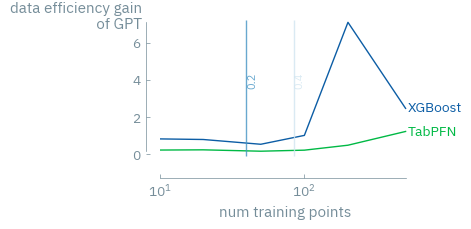

In [95]:
fig, ax = plt.subplots(1, 1, figsize=(ONE_COL_WIDTH_INCH, ONE_COL_GOLDEN_RATIO_HEIGHT_INCH))
ax.plot(
    grouped_res.loc[
        5,
        :,
    ].index,
    intersections,
    label="XGBoost",
)
ax.plot(
    grouped_res.loc[
        5,
        :,
    ].index,
    intersections_tabpfn,
    label="TabPFN",
)

matplotx.line_labels()
add_kappa_vlines(
    grouped_res.loc[5, :].index, grouped_res.loc[5, :]["kappa"]["mean"], ymax=7.2, ymin=-0.1
)
ylabel_top("data efficiency gain\n  of GPT", x_pad=0.05, y_pad=-0.08)
plt.xlabel("num training points", labelpad=4)

plt.xscale("log")

range_frame(
    ax,
    grouped_res.loc[
        5,
        :,
    ].index,
    np.stack([intersections, intersections_tabpfn]).flatten(),
)

plt.savefig("polymer-5-data-efficiency.pdf", bbox_inches="tight")